# <b>Statistical Relational Learning and Knowledge Graphs</b>
<br>
Relational machine learning involves the study of applying statistical analysis on relational or graph structured data. Usual machine learning algorithms takes an input and converts it into a representative feature vector in terms of numerical or categorical attributes. This feature vector is then fed into a learning algorithm to learn a mapping from the feature vector to an output prediction. This learning can be performed by supervised, unsupervised or by using latent factor models. In statistical relational learning, objects bear relationships with other objects. Thus it is intuitive to represent this as a graph. The nodes of such a graph will be the objects and the edges will be the relationships between them. The main goals of statistical relational learning includes prediction of missing edges, prediction of properties of nodes and clustering of vertices based on their similarities. 

<b>Graph Representation</b> <br>
Knowledge graph models information in the form of relationships between entities. Graphs are useful in representing facts and are used to automatically mine information out of known data. Each such fact is represented using a triplet - (subject, predicate, object) or SPO object where subject and object are entities and predicate is the relationship between them. <br>
<br>
For example, lets consider the text from Wikipedia about the film Inception: <br><br> <i>Inception is a 2010 science fiction action film written and directed by Christopher Nolan, who also produced the film with his wife, Emma Thomas.</i>
<br>
<br>
On converting this into SPO triplets we get the following:
<table>
  <tr>
    <th>Subject</th>
    <th>Predicate</th>
    <th>Object</th>
  </tr>
  <tr>
    <td>Inception</td>
    <td>Genre</td>
    <td>Science Fiction Action</td>
  </tr>
  <tr>
    <td>Inception</td>
    <td>Released in</td>
    <td>2010</td>
  </tr>
  <tr>
    <td>Christopher Nolan</td>
    <td>Directed</td>
    <td>Inception</td>
  </tr>
  <tr>
    <td>Emma Thomas</td>
    <td>Produced</td>
    <td>Inception</td>
  </tr>
</table>

We can convert this information into a directed multigraph, leveraging the sematic structure of the words in the sentence using open source natural language processing packages like spacy. The direction of the edges in such a graph is from a subject to an object entity. Later we will create a similar network of nodes and edges using the networkx package.

<b>Open World Assumption</b><br>
Known facts fed into the Knowledge graph produce valid SPO triplets. There are usually two different paradigms being followed for the unknown triplets. Under the open world assumption, the non existing triplets are considered as unknown, the relationships can either be true or false. But with the closed world assumption, the non existing triplets are considered to be false relationships. The open world assumption more likely fits the real world scenarios as most of the data is missing, so we adopt this paradigm.

For illustration purposes, let take in a couple of simple sentences from which subject, object and predicate can easily be parsed. These sentences are fed into a python function to extract the SPO triplets and are plotted using networkx. It produces a directed graph from Subject to Object of the sentence with the Predicate as the edge property

In [128]:
import spacy
import matplotlib.pyplot as plt
import networkx.drawing.layout as draw
import networkx as nx # make sure the networkx package is 2.2 otherwise hyperopt package will break
from tqdm import tqdm
import urllib.request
import csv
import numpy as np
import pandas as pd
import tarfile

In [129]:
def plot_graph(facts, num_facts=100):
    facts = np.array(facts)
    kg_df = pd.DataFrame({'source':facts[:num_facts,0], 'target':facts[:num_facts,2], 'edge':facts[:num_facts,1]})
    G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                              edge_attr=True, create_using=nx.DiGraph())
    labels = nx.get_edge_attributes(G, 'edge')
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G,k=10)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=labels, font_weight='light')

In [130]:
def sample_knowledge_graph(sentences):
    nlp = spacy.load('en_core_web_sm')
    rows = []
    for sentence in sentences:
        doc = nlp(sentence)
        for token in doc:
            if 'subj' in token.dep_:
                sub = token.text
            elif 'obj' in token.dep_:
                obj = token.text
            elif 'ROOT' in token.dep_:
                pred = token.text
        rows.append([sub, pred, obj])
        
    plot_graph(rows) 

In [131]:
sentences = ["Inception manipulates thoughts",
                "Nolan wrote Inception", 
                "Dicaprio acts in Inception", 
                "Dicaprio won Oscar",
                "The Revenant won Oscar",
                "Nolan directed Interstellar"]

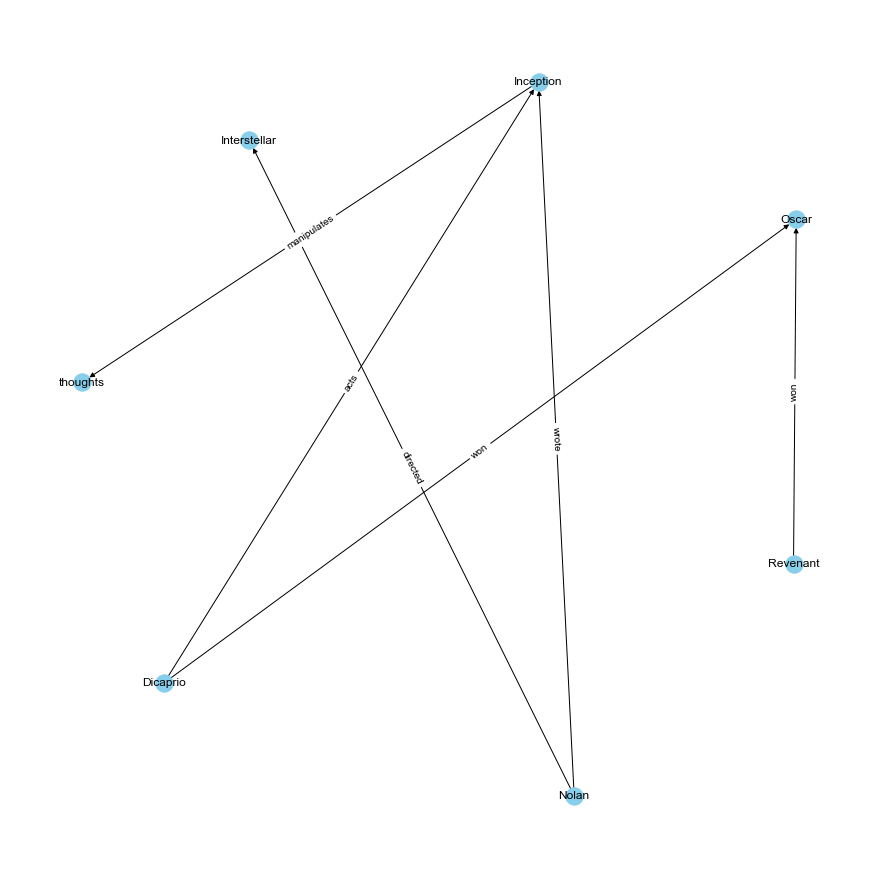

In [133]:
sample_knowledge_graph(sentences)

<b>Knowledge Bases</b><br>
Knowledge Bases store factual information in the form of relationships between entities. Creation of knowledge bases are influenced by the completeness, accuracy and quality of data. They are usually constructed by manually curated approaches, or by collaborative approaches. But both of these approaches depend on human experts and thus does not scale well. Recently, automatic knowledge base contruction is gaining much traction. In such methods, triplets are extracted using hand crafted rules and regular expressions or by using machine learning and natural language processing techniques. Few examples of knowledge base datasets include YAGO3-10, WN18, UMLS, NATIONS.

<b>Notations and Representations</b><br>
A knowledge graph is represented using a set of entities <b>E</b> and relations <b>R</b> between them. The set of facts in the knowledge graph is represented using the convention $(h,l,t)$ where $h,t$ are entities called head (or subject) and the tail (or object). $l$ is referred to as the relationship (or predicate) that exists between the subject and object <i>eg: (AlfredHitchcock, DirectorOf, Psycho)</i>

<b>Knowledge Graph Embedding</b><br>
Even though the graph structure is efficient in representing the underlying data, the symbolic nature of the triplets makes the knowledge graph difficult to manipulate. To tackle this issue, we use <i>knowledge graph embeddings</i>. The key idea is to embed the components of a knowledge graph including the entities and the relations into a continuous vector space to simplify the manipulations while preserving the inherent graph structure. <br>

A typical Knowledge graph embedding consists of mainly three steps:
 <ul>
  <li>Representing entities and relations</li>
  <li>Defining a scoring function to test the representative ability of the embeddings</li>
  <li>Learning the entity and relation representations</li>
</ul> 
The first step is usually done by transforming the entities and relations into a vector space represented using Gaussian Multivariate distributions or matrices or tensors. In the second step we define a scoring function $f$ to measure the goodness of our representations or in other words to measure its plausibility. In the open world assumption, facts observed in the knowledge graphs tend to have higher score than those yet unknown. Finally these embeddings are learn by solving an optimization problem that maximises the plausibility of the observed facts.

There are three main embedding techniques being used in the KG world: translational distance models, semantic matching models and projection based models. Translational models use distance-based scoring functions while the sematice models uses similarity based scoring functions. Lets discuss the basic translational distance model called TransE and apply some KG methods on it for starters.

<b>TransE aka Translations in the embedding space</b> <br>
In this model, the low level embeddings are represented using an energy based model. The relationships (predicates) are represented as translations in the embedding space: according to their definition, if the triplet $(h,l,t)$ holds, then the embedding of the tail entity $t$ should be close to the embedding of the head entity $h$ plus some vector that depends on the relationship $l$. Each vector and relationship is represented using one low dimensional vector. The basic idea behind the model is that the functional relation induced by the $l$ vector corresponds to a translation of the entity embeddings. Thus we want that $h+l$ almost near $t$ in the embedding space when $(h,l,t)$ exists in the KG otherwise $h+l$ should be far away from $t$.


The energy of a triplet is equal to $(h,l,t)$  for some dissimilarity measure $d$ which is usually taken as the $L_1$ or $L_2$ norm. The cost function is defined as :

$\textit{L} = \sum_{(h,l,t)\epsilon S}\sum_{({h}',l,{t}')\epsilon {S}'} [\gamma + d(h+l, t) - d({h}'+l, {t}')]_{+}$

where $(h,l,t)$  comes from the initial knowledge graph dataset S and $({h}',l,{t}')$ is a corrupted triplet created by replacing either head or the tail using a random entity. Note that the embedding vector for a given entity is the same when the entity appears as the tail or the head of a triplet. Our objective is to reduce $d(h+l,t)$ and increase the distance $d({h}'+l,{t}')$ as $({h}',l,{t}')$ is an unknown fact. In other words, we want the distance due to known fact to be smaller and distance due to unknown fact to be larger. We use a margin value $\gamma$ to increase this width.

Enough with the theory, lets jump into some code and see knowledge graphs in action. Lets first take some of the datasets we discussed before. Here I am taking the YAGO3-10 dataset.

YAGO3-10 is a subset of YAGO3 knowledge base which consists of entities which have a minimum of 10 relations each. It has a total of 123182 entities and 37 relations. Most of the triplets deal with descriptive attributes of people such as citizenship, gender and profession. Here I am downloading the YAGO3 dataset from github into local storage for further processing.

In [134]:
def download_dataset():
    urllib.request.urlretrieve('https://github.com/TimDettmers/ConvE/raw/master/YAGO3-10.tar.gz','yago3-10.tar.gz')
    tar = tarfile.open('yago3-10.tar.gz','r:gz')
    tar.extractall()
    tar.close()
    

In [135]:
download_dataset()

This is a tsv (Tab Separated Values) file. Lets parse it and extract the subject, predicate, object triplets.

In [136]:
def extract_data_and_plot():
    with open('train.txt','rt') as file:
        response = csv.reader(file, delimiter='\t')
        rows = [row for row in response]
    return rows

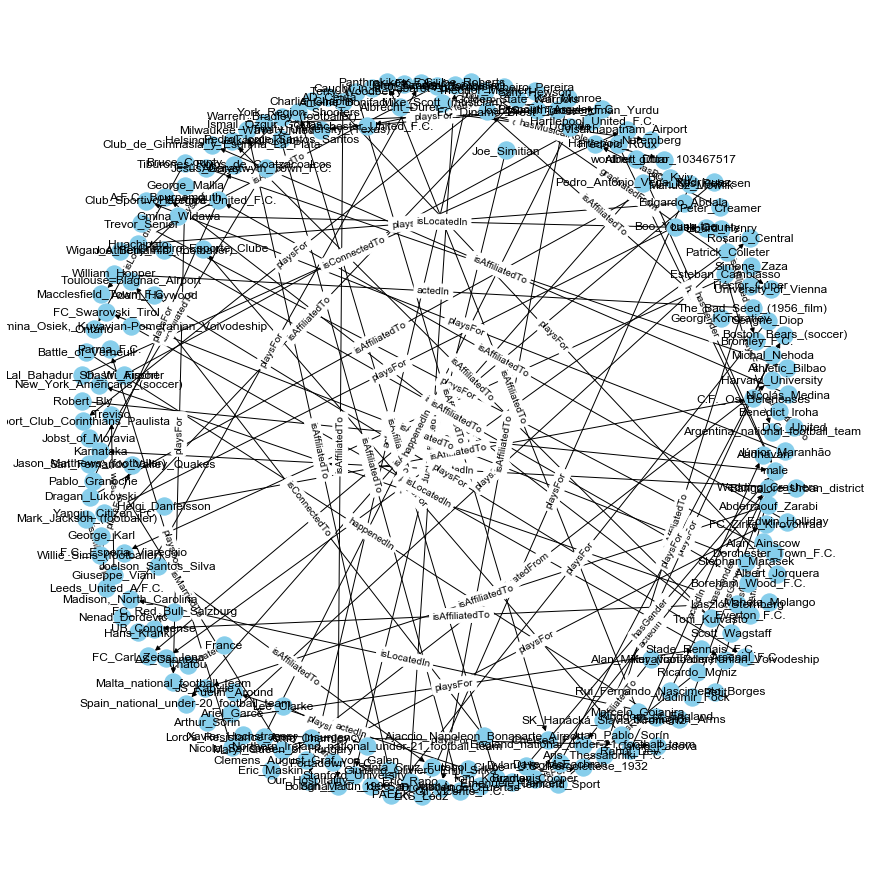

In [137]:
plot_graph(extract_data_and_plot(), num_facts=100)

I just plotted the first 100 slice of the input file. Still it is very difficult to extract knowledge out of this structure. So we will move to transE technique to convert the knowledge into embedding form. Though there are many extensions to TransE algorithm like TransH, TransD which project the embeddings to a hyperplane, TransE paved the way for translational model and is a seminal paper in this field. So it is important to know this basic algorithm to start with Knowledge Graph Embeddings. The algorithm is as follows:

<div style="border: 2px solid;
  padding: 5px;
  margin: 2px;">
$Learning TransE$ <br>
$input: Training\space set\space S={(h,l,t)}, margin\space \gamma, embeddings \space dimention\space k$<br>

$1.initialize\space l,e ←uniform(\frac{−6}{√k},\frac{−6}{√k}) for\space each\space l \space \epsilon \space L \space and\space e \space \epsilon \space E$<br>
$2.loop \space over \space epochs$<br>
$ \quad \quad normalize\space e\space and\space l\space embeddings$<br>
$\quad \quad for \space (h,l,t) \space \epsilon S_{batch} \space do$ <br>
$\quad \quad \quad \quad create \space corrupted \space version \space ({h}',l,{t}')$
$\quad \quad update \space embeddings \space with \space respect\space to\space  \sum_{((h,l,t), ({h}',l,{t}'))\epsilon T_{batch}} {\Delta[\gamma + d(h+l, t) - d({h}'+l, {t}')]_{+}}$
</div>

With the huge amount of data, its nearly impossibe to train this model using CPU. There are specialized packages which implements state of the art Knowledge graph algorithms like pykg2vec, AmpliGraph and OpenKE. Here we use pykg2vec to implement the KG using the above YAGO3-10 dataset.

In [11]:
!pip3 install pykg2vec

You should consider upgrading via the 'pip install --upgrade pip' command.


In [77]:
from pykg2vec.utils.kgcontroller import KnowledgeGraph
from pykg2vec.config.config import Importer, KGEArgParser
from pykg2vec.utils.trainer import Trainer
from pykg2vec.config.config import TransEConfig, BasicConfig
from pykg2vec.core.TransE import TransE
import os
def train_transE_on_YAGO3():
    args = KGEArgParser().get_args([])
    setattr(args, 'epochs', 5)
    setattr(args, 'dataset_name', 'yago')

    transEconfig = TransEConfig(args)
    
    model = TransE(transEconfig)
    trainer = Trainer(model=model)
    trainer.build_model()
    trainer.train_model()
    return model, transEconfig

In [78]:
model, config = train_transE_on_YAGO3()


------------------Global Setting--------------------
                    test_step : 10
               full_test_flag : False
                     test_num : 1000
                         hits : [1, 3, 5, 10]
                 loadFromData : False
                   save_model : True
                 disp_summary : True
                  disp_result : False
             early_stop_epoch : 50
                     patience : 3
              disp_triple_num : 20
               plot_embedding : False
         plot_training_result : True
          plot_testing_result : True
             plot_entity_only : False
              num_process_gen : 2
              num_process_evl : 1
         log_device_placement : False
          custom_dataset_path : None
                     path_tmp : /home/aswin/Documents/Information Retrieval/CSCE670-Information-Retrieval/dataset/YAGO3_10/intermediate
                  path_result : /home/aswin/Documents/Information Retrieval/CSCE670-Information-Retrieval/d

Ok, thats hardly 10 lines of code, but took like 5 minutes to run. Lets see what is happening under the hood. We are using the package pykg2vec as our framework for finding the knowledge graph embeddings. Let me take you for a quick ride on what it is.

<b>pykg2vec</b><br>
Pykg2vec is an open source python library which is fairly new and documented (will come back on that) and implements most of the state of the art Knowledge graph embedding algorithms like TransE, TransH, TransD, Complex, ConvE, Rescal etc. The package includes a whole lot of functionalities like automatic discovery of golden hyperparameters, a set of visualization tools for projecting the results of training and testing, project the embeddings into a 2D space using t-SNE algorithm etc. Another attractive element of this package is the use of GPU for training purposes. It inherently uses Tensorflow 2.2 as the backend for all the learning purposes. This makes the algorithm to run fairly faster. There are other KG frameworks in development called AmpliGraph and OpenKE, but we will come to that later.

Lets start with KGEArgParser. This is a class which implements the argument parser for the pykg2vec. It defines all the necessary arguments for the global and local configurations of all the modules. Either we can write all these configurations by ourselves as an object or use the inbuilt default parameters. Since we do not want to change many default parameters, lets stick with KGEArgParser. So we first call the KGEArgParser() to get all the default parameters required for all the models defined in pykg2vec. This will return an object containing default parameter values for hyperparameters like learning_rate, epochs, dataset_name etc as given below:

<code>args =  Namespace(C=0.0125, batch_training=128, cmax=0.05, cmin=5.0, crp_factor=0.01, dataset_name='Freebase15k', dataset_path=None, debug=False, early_stop_epoch=50, ent_hidden_size=50, epochs=100, exp=False, feature_map_dropout=0.2, figures='../figures', filter_sizes=[1, 2, 3], function='bilinear', gpu_frac=0.8, hidden_dropout=0.3, hidden_size=50, input_dropout=0.3, l1_flag=True, label_smoothing=0.1, learning_rate=0.01, lmbda=0.1, load_from_data=False, margin=0.8, model_name='TransE', ncluster=4, negrate=1, num_filters=50, num_process_evl=1, num_process_gen=2, optimizer='adam', plot_embedding=False, plot_entity_only=False, rel_hidden_size=50, result='../results', sampling='uniform', save_model=True, step_before=10, test_num=1000, test_step=10, tmp='../intermediate', training_threshold=3.5, weight_norm=False)
</code>

I will suggest to call this first to set all the parameters to default first and then modify the parameters you want to change later like I did for the epoch and learning rate. 
Now we got all the parameters for the KG algorithm. We can define a config object of the KG algorithm, TransEConfig in the example, and feed the above created arg list. In this step the dataset specified using 'dataset_name' will be downloaded and stored into the local disk along with splitting the data into train, valid and test sets.<br> 
Now call the TransE model with this TransEConfig object and feed this into the Trainer which will build the model and train it on the training set.

Lets now write a function to plot the training loss against each epoch

In [113]:
import re
import pandas as pd
import seaborn
def plot_results(algorithm, config):
    folder = config.path_result
    files = os.listdir(folder)
    training_file = None
    training_file_no = -1
    for file in files:
        names = re.split('[_ .]',file)
        
        if 'Training' == names[1] and algorithm == names[0] and training_file_no < int(names[3]):
            training_file = file
            training_file_no = int(names[3])
    with open(os.path.join(folder, training_file), 'r') as file:
        df = pd.read_csv(file)
        plt.figure()
        ax = seaborn.lineplot(x="Epochs", y="Loss", markers=True, dashes=False, data=df)
            

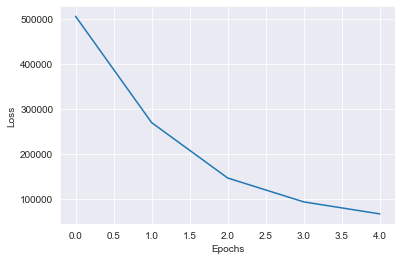

In [114]:
plot_results('TransE', config)

The evaluation metrics in Knowledge Graph Embedding setting includes Mean Rank and Hits@10. Lower value for MR and higher values for Hits@10 indicate good performance. In the above test run, the results are not great, but we only ran 5 epochs and tested on 1000 triplets and the researchers in the actual paper ran about 1000 epochs with early stopping using validation set.

Lets first take the hyperparameters defined in the TransE paper and apply it on Freebase15k dataset (https://everest.hds.utc.fr/lib/exe/fetch.php?media=en:fb15k.tgz)

In [73]:
from pykg2vec.config.hyperparams import HyperparamterLoader
def get_default_params(dataset, algorithm):
    hyperparams = HyperparamterLoader().load_hyperparameter(dataset, algorithm)
    print("The hyperparameters used in the paper is ", hyperparams)
    return hyperparams

In [74]:
hyperparams = get_default_params(dataset='freebase15k', algorithm='transe')

The hyperparameters used in the paper is  {'learning_rate': 0.01, 'L1_flag': True, 'hidden_size': 50, 'batch_size': 128, 'epochs': 1000, 'margin': 1.0, 'optimizer': 'sgd', 'sampling': 'uniform', 'neg_rate': 1}


Now lets pass these hyperparameters into the model and train the model using the training set. The intermediate results are obtained by using validation set.

In [115]:
def load_and_train_transe(hyperparams):
    
    args = KGEArgParser().get_args([])
    d = vars(args)
    for key,val in hyperparams.items():
        setattr(args, key, val)
    setattr(args, 'epochs', 100)
    transEconfig = TransEConfig(args)
    model = TransE(transEconfig)
    trainer = Trainer(model=model, trainon='train', teston='valid')
    trainer.build_model()
    trainer.train_model()
    return model, transEconfig

In [116]:
model, config = load_and_train_transe(hyperparams)


------------------Global Setting--------------------
                    test_step : 10
               full_test_flag : False
                     test_num : 1000
                         hits : [1, 3, 5, 10]
                 loadFromData : False
                   save_model : True
                 disp_summary : True
                  disp_result : False
             early_stop_epoch : 50
                     patience : 3
              disp_triple_num : 20
               plot_embedding : False
         plot_training_result : True
          plot_testing_result : True
             plot_entity_only : False
              num_process_gen : 2
              num_process_evl : 1
         log_device_placement : False
          custom_dataset_path : None
                     path_tmp : /home/aswin/Documents/Information Retrieval/CSCE670-Information-Retrieval/dataset/FB15k/FB15k/intermediate
                  path_result : /home/aswin/Documents/Information Retrieval/CSCE670-Information-Retrieva

--hits1                        : 0.0755 
--filtered hits1               : 0.1320 
--hits3                        : 0.1790 
--filtered hits3               : 0.2895 
--hits5                        : 0.2460 
--filtered hits5               : 0.3560 
--hits10                        : 0.3500 
--filtered hits10               : 0.4655 
---------------------------------------------------------
3774/3774 [==============================] - 5s 1ms/step - acc_loss: 8091.0356 - loss: 1.3448
Epoch[32/100]
3774/3774 [==============================] - 6s 1ms/step - acc_loss: 7996.1694 - loss: 5.1618
Epoch[33/100]
3774/3774 [==============================] - 6s 1ms/step - acc_loss: 7777.6904 - loss: 0.5008A: 2s  - ETA: 1s - acc_loss: 63
Epoch[34/100]
3774/3774 [==============================] - 6s 1ms/step - acc_loss: 7833.7920 - loss: 2.1689
Epoch[35/100]
3774/3774 [==============================] - 6s 1ms/step - acc_loss: 7551.7051 - loss: 0.2510A: 
Epoch[36/100]
3774/3774 [===========================

---------------------------------------------------------
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5579.6973 - loss: 0.8536
Epoch[72/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5547.1943 - loss: 0.8299s - acc_loss: 47.2426 - loss: 0.331 - ETA: 5s - acc_loss: 97.6104 - loss - ETA: 1
Epoch[73/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5548.3730 - loss: 0.9770
Epoch[74/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5464.3301 - loss: 0.0534
Epoch[75/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5621.0737 - loss: 0.1607
Epoch[76/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5419.7686 - loss: 2.6896
Epoch[77/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5418.8716 - loss: 1.8971
Epoch[78/100]
3774/3774 [==============================] - 6s 2ms/step - acc_loss: 5364.7217 - loss: 1.4299
Epoch[79/10

Both the Hits@10 and Mean Rank keeps on decreasing and the final results are <br>
<table>
  <tr>
    <th>Mean Rank</th>
    <th>Hits@10</th>
  </tr>
  <tr>
    <td>92.23</td>
    <td>52.75</td>
  </tr>
</table>
These results are close to the results in the paper which is 125 and 47.1 (we got better values for both of them!!). 

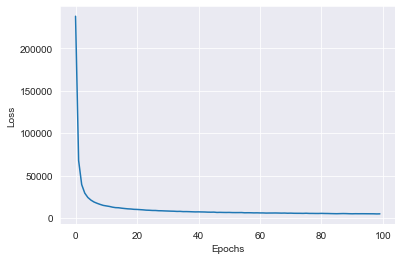

In [117]:
plot_results('TransE', config)

Now lets test the model against the test set and see how it performs against it.

In [118]:
from pykg2vec.utils.evaluator import Evaluator
def evaluate_on_test_data(model):
    evaluator = Evaluator(model=model, debug=False, tuning=False, data_type='test')
    evaluator.test(epoch=1)

In [119]:
evaluate_on_test_data(model)

Testing [1000/59071] Triples
1000/1000 [==============================] - 2s 2ms/step
------Test Results for Freebase15k: Epoch: 1 --- time: 1.16------------
--# of entities, # of relations: 14951, 1345
--mr,  filtered mr             : 223.8575, 81.5615
--mrr, filtered mrr            : 0.1758, 0.2811
--hits1                        : 0.0800 
--filtered hits1               : 0.1565 
--hits3                        : 0.1950 
--filtered hits3               : 0.3330 
--hits5                        : 0.2605 
--filtered hits5               : 0.4145 
--hits10                        : 0.3760 
--filtered hits10               : 0.5235 
---------------------------------------------------------


Not bad huh, the results are pretty good!!

We ran the KG Embedding algorithm TransE on YAGO3 and Freebase datasets. But we can also run new and improved KG algorithms like ConvE and Complex using the same methods. Additionally pykg2vec also provides utility functions for hyperparameter optimization, loading of custom dataset and various evaluation metrics. Now lets try to call an advanced KG algorithm for link prediction. This algorithm is called ComplEx. ComplEx is an enhanced version of DistMult in that it uses complex-valued embeddings to represent both entities and relations. Using the complex-valued embedding allows the defined scoring function in ComplEx to differentiate that facts with assymmetric relations. Further details can be seen in the paper. Lets implement this algorithm using pykg2vec.

In [120]:
from pykg2vec.config.config import ComplexConfig
from pykg2vec.core.Complex import Complex
from argparse import Namespace

def load_and_train_complex():
    hyperparams = get_default_params(dataset='freebase15k', algorithm='complex')
    args = KGEArgParser().get_args([])
    
    for key,val in hyperparams.items():
        setattr(args, key, val)
    setattr(args, 'epochs', 100)
    
    complexConfig = ComplexConfig(args)
    model = Complex(complexConfig)
    trainer = Trainer(model=model, trainon='train', teston='valid')
    trainer.build_model()
    trainer.train_model()
#     trainer.display()
    return model, complexConfig

In [121]:
model_complex, config = load_and_train_complex()

The hyperparameters used in the paper is  {'learning_rate': 0.5, 'hidden_size': 200, 'batch_size': 5000, 'epochs': 1000, 'optimizer': 'adagrad', 'sampling': 'uniform', 'neg_rate': 10, 'lmbda': 0.0001}

------------------Global Setting--------------------
                    test_step : 10
               full_test_flag : False
                     test_num : 1000
                         hits : [1, 3, 5, 10]
                 loadFromData : False
                   save_model : True
                 disp_summary : True
                  disp_result : False
             early_stop_epoch : 50
                     patience : 3
              disp_triple_num : 20
               plot_embedding : False
         plot_training_result : True
          plot_testing_result : True
             plot_entity_only : False
              num_process_gen : 2
              num_process_evl : 1
         log_device_placement : False
          custom_dataset_path : None
                     path_tmp : /home/aswi

--filtered hits1               : 0.2260 
--hits3                        : 0.2195 
--filtered hits3               : 0.4210 
--hits5                        : 0.3050 
--filtered hits5               : 0.5085 
--hits10                        : 0.4275 
--filtered hits10               : 0.6175 
---------------------------------------------------------
3774/3774 [==============================] - 9s 2ms/step - acc_loss: 24522.1816 - loss: 20.5238
Epoch[32/100]
3774/3774 [==============================] - 9s 2ms/step - acc_loss: 24048.5254 - loss: 4.7237
Epoch[33/100]
3774/3774 [==============================] - 9s 2ms/step - acc_loss: 23569.9102 - loss: 4.0865
Epoch[34/100]
3774/3774 [==============================] - 8s 2ms/step - acc_loss: 23540.5332 - loss: 5.8596
Epoch[35/100]
3774/3774 [==============================] - 9s 2ms/step - acc_loss: 22902.3945 - loss: 7.7581: 0s - acc_loss: 22058.1484 
Epoch[36/100]
3774/3774 [==============================] - 9s 2ms/step - acc_loss: 22826.0195

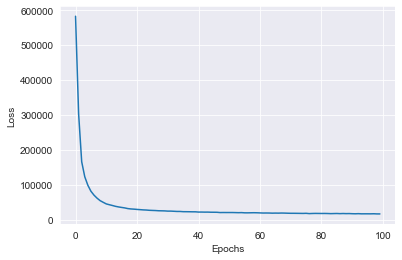

In [122]:
plot_results('Complex', config)

In [123]:
evaluate_on_test_data(model_complex)

Testing [1000/59071] Triples
1000/1000 [==============================] - 26s 26ms/step
------Test Results for Freebase15k: Epoch: 1 --- time: 23.48------------
---------------------------------------------------------
--# of entities, # of relations: 14951, 1345
--mr,  filtered mr             : 388.1730, 214.9315
--mrr, filtered mrr            : 0.2097, 0.4476
--hits1                        : 0.1035 
--filtered hits1               : 0.3105 
--hits3                        : 0.2340 
--filtered hits3               : 0.5385 
--hits5                        : 0.3195 
--filtered hits5               : 0.6095 
--hits10                        : 0.4495 
--filtered hits10               : 0.6895 


Hits@10 improved dramatically!!<br>
Instead of calling each function separately by importing separate functions and their config, we can use a wrapper called Importer which takes in the name of the algorithm and returns the constructer of config and model dynamically. This helps us in reducing the code. This can come in handy if we want to run multiple models on a dataset. Lets call the RotatE model using Importer class.

In [124]:
from pykg2vec.config.config import Importer
def learn_using_importer():
    hyperparams = get_default_params(dataset='freebase15k', algorithm='rotate')
    args = KGEArgParser().get_args([])
    d = vars(args)
    for key,val in hyperparams.items():
        setattr(args, key, val)
    setattr(args, 'epochs', 100)
    config_def, model_def = Importer().import_model_config('rotate')
    config = config_def(args)
    model = model_def(config)
    trainer = Trainer(model=model, trainon='train', teston='valid')
    trainer.build_model()
    trainer.train_model()
    return model, config

In [125]:
model_rotate, config = learn_using_importer()

The hyperparameters used in the paper is  {'learning_rate': 0.01, 'L1_flag': True, 'hidden_size': 50, 'batch_size': 128, 'epochs': 1000, 'margin': 1.0, 'optimizer': 'adam', 'sampling': 'uniform', 'neg_rate': 1}

------------------Global Setting--------------------
                     neg_rate : 1
                    test_step : 10
               full_test_flag : False
                     test_num : 1000
                         hits : [1, 3, 5, 10]
                 loadFromData : False
                   save_model : True
                 disp_summary : True
                  disp_result : False
             early_stop_epoch : 50
                     patience : 3
              disp_triple_num : 20
               plot_embedding : False
         plot_training_result : True
          plot_testing_result : True
             plot_entity_only : False
              num_process_gen : 2
              num_process_evl : 1
         log_device_placement : False
          custom_dataset_path : Non

--# of entities, # of relations: 14951, 1345
--mr,  filtered mr             : 353.9990, 247.3535
--mrr, filtered mrr            : 0.0809, 0.1063
--hits1                        : 0.0045 
--filtered hits1               : 0.0050 
--hits3                        : 0.0885 
--filtered hits3               : 0.1355 
--hits5                        : 0.1405 
--filtered hits5               : 0.2000 
--hits10                        : 0.2390 
--filtered hits10               : 0.3075 
---------------------------------------------------------
3774/3774 [==============================] - 8s 2ms/step - acc_loss: 36768.4766 - loss: 18.1430
Epoch[32/100]
3774/3774 [==============================] - 8s 2ms/step - acc_loss: 37737.5039 - loss: 7.9104
Epoch[33/100]
3774/3774 [==============================] - 8s 2ms/step - acc_loss: 37384.3125 - loss: 14.1442
Epoch[34/100]
3774/3774 [==============================] - 8s 2ms/step - acc_loss: 35761.2539 - loss: 8.3537
Epoch[35/100]
3774/3774 [==================

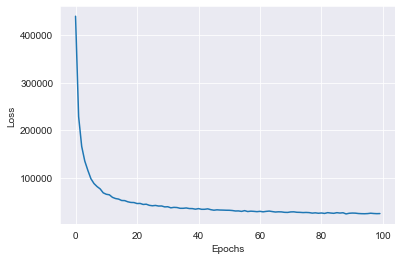

In [126]:
plot_results('RotatE', config)

In [127]:
evaluate_on_test_data(model_rotate)

Testing [1000/59071] Triples
1000/1000 [==============================] - 2s 2ms/step
------Test Results for Freebase15k: Epoch: 1 --- time: 1.61------------
--# of entities, # of relations: 14951, 1345
--mr,  filtered mr             : 336.8025, 197.4185
--mrr, filtered mrr            : 0.0909, 0.1288
--hits1                        : 0.0110 
--filtered hits1               : 0.0140 
--hits3                        : 0.1025 
--filtered hits3               : 0.1720 
--hits5                        : 0.1605 
--filtered hits5               : 0.2410 
--hits10                        : 0.2465 
--filtered hits10               : 0.3535 
---------------------------------------------------------


We did not see an improvement in the performance, but we only ran 100 epochs but the golder hyperparameter value for epoch is 1000. Even though the hits@10 did not outperform TransE in 100 epochs, it showed a clear trend of decreasing hits@10 value.

<b>Drawbacks and Alternatives</b><br>
The major drawback that I felt about the package is that the latest code is different from what is present in the documentation. I had to manually check the github of the package to see the latest code and change the api calls accordingly. There are other alternatives for performing Knowledge Graph Embedding algorithms like OpenKE and Ampligraph. The main problem with Ampligraph and OpenKE is that they don't have as much KG algorithms built out of the box compared to pykg2vec. Ampligraph is also implemented on top of the deprecated Tensorflow 1. Overall pykg2vec is a great package to start learning Knowledge Graph Embeddings.

REFERENCES

 <ul>
  <li><a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7358050&tag=1">A Review of Relational MachineLearning for Knowledge Graphs</a></li>
  <li><a href="https://ieeexplore.ieee.org/document/8047276">Knowledge Graph Embedding: A Survey of Approaches and Applications</a></li>
  <li><a href="https://arxiv.org/abs/1703.08098">An overview of embedding models of entities and relationships for knowledge base completion</a></li>
  <li><a href="https://pypi.org/project/pykg2vec/">pykg2vec PyPI</a></li>
</ul> 